# 2. Entrenamiento de RNNs en una Serie de Tiempo

**2.0 Imports necesarios**

In [1]:
import pandas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
import matplotlib.pyplot as plt
import time

/home/seba/.virtualenvs/tareas-ml/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)


**2.1 Creación de conjuntos de entrenamiento y prueba**

En primer lugar, se crean los conjuntos de entrenamiento y de prueba por medio de la función *create_sets*. Esta función también se encarga de escalar los datos de cada conjunto, de tal manera que cada cada atributo de cada ejemplo tendrá un valor entre 0 y 1. El dataset original está compuesto por un total de 144 registros, de los cuales 96 estarán destinados a conformar el conjunto de entrenamiento, mientras que los 48 restantes formarán parte del conjunto de pruebas.

In [2]:
# Función para la creación de conjuntos de entrenamiento y prueba
def create_sets(file_name):
    # Se lee archivo que contiene todos los datos
    dataframe = pandas.read_csv(file_name, sep=',', usecols=[1], engine='python', skipfooter=3)
    # Se utiliza precisión de 32 bits para atributos numéricos
    dataframe[:] = dataframe[:].astype('float32')
    # Se crean conjuntos de entrenamiento y de prueba
    df_train, df_test = dataframe[0:96].values, dataframe[96:].values
    # Se escalan los datos de cada conjunto
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled = scaler.transform(df_test)
    return scaler, list(stream_train_scaled), list(stream_test_scaled)

# Se crean conjuntos a partir de archivo .csv
scaler, train_set, test_set = create_sets('international-airline-passengers.csv')

**2.2 Separación de atributos predictores y atributo a predecir**

Ya creados los conjuntos de entrenamiento y de prueba, se procede a construir, para cada caso, la matriz X y el vector Y.

Considerar, por ejemplo, un lag = 3. En tal caso, la matriz X contendrá, para cada registro, la cantidad de pasajeros en los tiempos x(t-2), x(t-1) y x(t), o en otras palabras, los atributos predictores. Por otro lado, el vector Y almacenará en la casilla correspondiente la cantidad de pasajeros en el tiempo x(t+1), es decir, el atributo a predecir. El procedimiento descrito será llevado a cabo por medio de la función *create_dataset*.

In [3]:
# Función encargada de separar valores predictores y valores a predecir
def create_dataset(sequence, lag):
    dataX = []
    dataY = []
    for i in range(lag, len(sequence)):
        # Se crea matriz X
        dataX.append(sequence[i - lag : i])
        # Se crea vector Y
        dataY.append(sequence[i])
    return np.array(dataX), np.array(dataY)

Así, se crea la matriz X y el vector Y en base a los conjuntos de entrenamiento y de prueba. Se utilizará lag = 3, en primera instancia.

In [4]:
# Inicialmente, se usará lag = 3
lag = 3
# Se crean matrices X y vectores Y en base a conjuntos de entrenamiento y prueba
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)

Para trabajar adecuadamente con las matrices X, es necesario redimensionarlas.

In [5]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

De esta forma, cada matriz X posee dimensiones (número de ejemplos, time step, número de atributos predictores) tanto para el caso de entrenamiento como para el caso de pruebas. Notar que, por ahora, se está trabajando con un time step = 1.

**2.3 Entrenamiento de red LSTM**

A partir de las matrices creadas en la sección anterior, se entrena y posteriormente se evalúa una red LSTM. Recordar que se está utilizando un lag de 3. Además, para este caso en particular, se trabajará con cuatro bloques LSTM, función de activación tanh y función de activación sigmoide para el paso recurrente. Para medir la pérdida en el entrenamiento, se usará Mean Squared Error (MSE), mientras que como método de optimización, se usará Adam. Se llevarán a cabo 100 epochs, con batches de tamaño 1.

In [6]:
ti = time.time()
# Se define modelo
model = Sequential()
# Se define capa LSTM
model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
# Se define capa densa
model.add(Dense(1))
# Se definen parámetros de entrenamiento
model.compile(loss='mean_squared_error', optimizer='adam')
# Se entrena modelo
model.fit(trainX, trainY, epochs=100, batch_size=1)
tf = time.time()

Epoch 1/100
93/93 [==============================] - 1s - loss: 0.1004     
Epoch 2/100
93/93 [==============================] - 1s - loss: 0.0459     
Epoch 3/100
93/93 [==============================] - 1s - loss: 0.0267     
Epoch 4/100
93/93 [==============================] - 1s - loss: 0.0210     
Epoch 5/100
93/93 [==============================] - 1s - loss: 0.0178     
Epoch 6/100
93/93 [==============================] - 1s - loss: 0.0154     
Epoch 7/100
93/93 [==============================] - 1s - loss: 0.0134     
Epoch 8/100
93/93 [==============================] - 1s - loss: 0.0117     
Epoch 9/100
93/93 [==============================] - 1s - loss: 0.0104     
Epoch 10/100
93/93 [==============================] - 1s - loss: 0.0096     
Epoch 11/100
93/93 [==============================] - 1s - loss: 0.0090     
Epoch 12/100
93/93 [==============================] - 1s - loss: 0.0085     
Epoch 13/100
93/93 [==============================] - 1s - loss: 0.0082     
Epoch 14

**2.4 Determinación de error de entrenamiento y de prueba**

A partir del modelo entrenado en la sección 2.3, se realizan predicciones tanto en el modelo de entrenamiento como en el de prueba. Junto con esto, se denormalizan los valores reales y los valores predichos para posteriormente determinar el error de predicción en la escala original en que se encontraban los datos.

In [7]:
# Se predicen valores en conjunto de entrenamiento
trainPredict = model.predict(trainX)
# Se predicen valores en conjunto de prueba
testPredict = model.predict(testX)
# Datos reales y predichos de entrenamiento son denormalizados
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
# Datos reales y predichos de prueba son denormalizados
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

Así, en base a los valores denormalizados, se procede a determinar el error de predicción tanto de entrenamiento como de prueba. En cada caso, lo que se computará será el RMSE.

In [8]:
# Se determina error de entrenamiento
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
# Se determina error de prueba
testScore = math.sqrt(mean_squared_error(testY, testPredict))
# Se determina tiempo de entrenamiento
print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 151.644290924 [s]
Error de entrenamiento: 23.1198275993 RMSE
Error de prueba: 69.9123963547 RMSE


Luego, se observa que el tiempo requerido para entrenar el modelo es de aproximádamente 151,64 [s]. Por otra parte, el error de entrenamiento es de 23,12 RMSE, mientras que el error de prueba es de 69,91 RMSE, aumentando considerablemente con respecto al error de entrenamiento, en base a lo cual se puede inferior que el modelo está sobreajustado.

**2.5 Comparación de predicciones**

A continuación, se procede a graficar, para cada conjunto de datos, la evolución de la serie en función del tiempo. En cada gráfico, se compara la evolución de la serie original en contraste con la serie predicha. Notar que como se está trabajando con lag = 3, las curvas asociadas a las series predichas comienzan en el tiempo lag + 1 = 4.

Primero, se grafican las series obtenidas para el conjunto de entrenamiento.

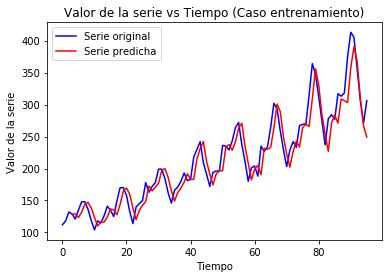

In [9]:
plt.plot(range(len(train_set)), scaler.inverse_transform(train_set), 'b')
plt.plot(range(len(train_set))[lag:], list(trainPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso entrenamiento)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

El gráfico anterior muestra como existen escasas diferencias entre una curva y otra, lo que es consistente con el "aceptable" error de entrenamiento percibido.

De forma, análoga se construye el gráfico descrito para el caso del conjunto de pruebas.

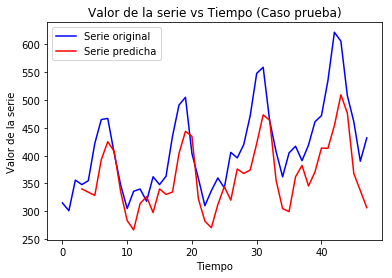

In [10]:
plt.plot(range(len(test_set)), scaler.inverse_transform(test_set), 'b')
plt.plot(range(len(test_set))[lag:], list(testPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso prueba)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

Es posible ver como las curvas se distancian cada vez más entre si a medida que el tiempo avanza, hecho que puede tener su origen en la propagación del error. Además, se observan anomalías, como la presencia de máximos locales en la serie original que se corresponden con mínimos en la serie predicha. 

**2.6 Determinación de bloques LSTM**

Con el fin de mejorar los resultados obtenidos anteriormente, se requiere conocer cual es la cantidad de bloques LSTM que permitirá disminuir el error y/o el tiempo de entrenamiento. Tal cantidad será determinada por medio K-fold Cross Validation, con K = 5, por lo que, para cada tamaño de bloque posible, se informa el tiempo y el error **promedio**. Se experimentará con bloques de tamaño 4, 6, 8, 10 y 12. El lag continuará siendo 3.

In [11]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Se definen los folds a utilizar
kfold = cross_validation.KFold(trainX.shape[0], 5)

# Se determina el tiempo y error de entrenamiento para cada cantidad de bloques posible
for nb in range(4, 13, 2):
    cv_errors = []
    times = []
    print 'Numero de bloques:', nb
    for i, (train, val) in enumerate(kfold):
        model = None
        ti = time.time()
        model = Sequential()
        model.add(LSTM(nb, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX[train], trainY[train], epochs=100, batch_size=1, verbose=0)
        tf = time.time()
        times.append(tf - ti)
        trainPredict_val = model.predict(trainX[val])
        trainPredict_val = scaler.inverse_transform(trainPredict_val)
        trainY_val = scaler.inverse_transform(trainY[val])
        error = math.sqrt(mean_squared_error(trainY_val, trainPredict_val))
        cv_errors.append(error)
    mean_time = np.mean(times)
    mse_cv = np.mean(cv_errors)
    print 'Tiempo de entrenamiento promedio:', tf - ti, '[s]'
    print 'Error promedio:', mse_cv
    print ''

Numero de bloques: 4
Tiempo de entrenamiento promedio: 94.1440439224 [s]
Error promedio: 24.9563698551

Numero de bloques: 6
Tiempo de entrenamiento promedio: 102.017626047 [s]
Error promedio: 23.996260032

Numero de bloques: 8
Tiempo de entrenamiento promedio: 103.57533884 [s]
Error promedio: 22.9543083832

Numero de bloques: 10
Tiempo de entrenamiento promedio: 31.4311478138 [s]
Error promedio: 21.6224803015

Numero de bloques: 12
Tiempo de entrenamiento promedio: 34.2996850014 [s]
Error promedio: 22.3339488603



Los resultados muestran que no existe gran diferencia entre los errores obtenidos para cada cantidad de bloques posible. El error más bajo es conseguido con 10 bloques (21,62 RMSE), cantidad con la que también se obtiene el tiempo de entrenamiento más bajo, por lo que para los experimentos a realizar en las secciones posteriores se utilizarán siempre 10 bloques.

Como observación, es interesante ver que no existe una relación, ya sea directa o indirecta, entre el número de bloques utilizados y el error de entrenamiento, así como tampoco entre el número de bloques y el tiempo de entrenamiento. 

**2.7 Variación de lag**

En esta sección, se evaluará el impacto de modificar el lag en términos del tiempo de entrenamiento y el error de prueba. En otras palabras, los valores futuros serán determinados a partir de una cantidad variable de valores pasados. Se trabará con lags 1, 2, 3 y 4.

In [12]:
for lag in range(1, 5):
    trainX, trainY = create_dataset(train_set, lag)
    testX, testY = create_dataset(test_set, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    ti = time.time()
    model = Sequential()
    model.add(LSTM(10, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    tf = time.time()
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    
    print 'Lag:', lag
    print 'Tiempo de entrenamiento:', tf - ti, '[s]'
    print 'Error de entrenamiento:', trainScore, 'RMSE'
    print 'Error de prueba:', testScore, 'RMSE\n'

Lag: 1
Tiempo de entrenamiento: 38.9600961208 [s]
Error de entrenamiento: 23.0858198495 RMSE
Error de prueba: 50.6355843488 RMSE

Lag: 2
Tiempo de entrenamiento: 38.2354969978 [s]
Error de entrenamiento: 21.2587592529 RMSE
Error de prueba: 56.3153569961 RMSE

Lag: 3
Tiempo de entrenamiento: 37.7705950737 [s]
Error de entrenamiento: 21.8260095946 RMSE
Error de prueba: 59.410653358 RMSE

Lag: 4
Tiempo de entrenamiento: 37.3015160561 [s]
Error de entrenamiento: 21.9020619436 RMSE
Error de prueba: 63.4056897616 RMSE



Los resultados muestran que el tiempo de entrenamiento aumenta con la variación del lag, si se compara con el caso de lag = 3 y 10 bloques LSTM. Además, se observa que el error de prueba tiende a aumentar a medida que también lo hace el lag. Esto es, el error de prueba más bajo se consigue con lag = 1, siendo este de un 48,55 RMSE. Para dicho lag, el tiempo de entrenamiento fue de 34,23 [s].

Notar, por otro lado, que independiente del lag utilizado, el error de prueba siempre resultó ser más bajo respecto al caso original, en que se utilizó lag = 3 y número de bloques = 4, recordando que en la presente sección siempre se usaron 10 bloques, reafirmando la conveniencia de utilizar la recien mencionada cantidad de bloques.

**2.8 Comparación con RNN simple y GRU**

Se desea comparar el rendimiento de las redes LSTM implementadas hasta ahora con el de una RNN simple y el de una Gated Recurrent Unit (GRU). Se considerará lag = 3 y 10 bloques.

Primero se determina el rendimiento de la GRU.

In [13]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
ti = time.time()
model = Sequential()
model.add(GRU(10, input_shape=(None, lag), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 30.681374073 [s]
Error de entrenamiento: 22.9943455919 RMSE
Error de prueba: 73.8763318143 RMSE


...

De forma análoga, se estudia el rendimiento de la RNN simple.

In [15]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

ti = time.time()
model = Sequential()
model.add(SimpleRNN(10, input_shape=(None, lag), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 19.7333681583 [s]
Error de entrenamiento: 24.794535324 RMSE
Error de prueba: 52.5739156004 RMSE


...

**2.9 Entrenamiento de red LSTM con timestep = 3**

In [16]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

ti = time.time()
model = Sequential()
model.add(LSTM(10, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

Epoch 1/100
95/95 [==============================] - 0s - loss: 0.1204     
Epoch 2/100
95/95 [==============================] - 0s - loss: 0.0548     
Epoch 3/100
95/95 [==============================] - 0s - loss: 0.0334     
Epoch 4/100
95/95 [==============================] - 0s - loss: 0.0280     
Epoch 5/100
95/95 [==============================] - 0s - loss: 0.0248     
Epoch 6/100
95/95 [==============================] - 0s - loss: 0.0217     
Epoch 7/100
95/95 [==============================] - 0s - loss: 0.0188     
Epoch 8/100
95/95 [==============================] - 0s - loss: 0.0163     
Epoch 9/100
95/95 [==============================] - 0s - loss: 0.0136     
Epoch 10/100
95/95 [==============================] - 0s - loss: 0.0116     
Epoch 11/100
95/95 [==============================] - 0s - loss: 0.0101     
Epoch 12/100
95/95 [==============================] - 0s - loss: 0.0088     
Epoch 13/100
95/95 [==============================] - 0s - loss: 0.0076     
Epoch 14

In [17]:
print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 43.8619568348 [s]
Error de entrenamiento: 22.9169657 RMSE
Error de prueba: 49.1911529774 RMSE


**2.10 Entrenamiento de red LSTM con memoria entre batches**

**2.10.1 Batch size = 1**

In [18]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1
ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0108     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0142     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0111     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0105     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0101     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0099     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0097     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0096     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0094     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0093     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0092     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0090     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0089     
Epoch 1/1
95/95 [=====================

In [19]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 39.4478318691 [s]
Error de entrenamiento: 20.7738267992 RMSE
Error de prueba: 44.4142693212 RMSE


**2.10.2 Batch size = 3**

In [20]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 3
ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
93/93 [==============================] - 0s - loss: 0.1576     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0431      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0328     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0323     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0265     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0227     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0192     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0163     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0141      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0125      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0115      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0110      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0108      
Epoch 1/1
93/93 [===============

In [21]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 24.7862110138 [s]
Error de entrenamiento: 29.2695560127 RMSE
Error de prueba: 72.1762234158 RMSE


**2.11 Entrenamiento de LSTM apilada**

In [22]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1

ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0126     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0252     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0251     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0174     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0142     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0143     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0142     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0153     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0146     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0151     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0154     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0153     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0154     
Epoch 1/1
95/95 [=====================

In [23]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 103.771305084 [s]
Error de entrenamiento: 17.4679926672 RMSE
Error de prueba: 87.0944367797 RMSE
